In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import numpy.random as rand
import scipy.stats as stats 
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor 
from sklearn.model_selection import StratifiedKFold

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time
from collections import deque
plt.style.use('ggplot')

references:

https://www.youtube.com/watch?v=PuZY9q-aKLw&t=426s

https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

## Train/Test Data

Creating train/test data

# converting days to max and min for neural network prediction

In [5]:
def datetime_conversion(week_start_lst):
    week_start_df = pd.DataFrame(columns=['year', 'month', 'day'])
    for i, week in enumerate(week_start_lst):
        split_week = week.split('-')
        week_start_df.loc[i] = split_week[0], split_week[1], split_week[2]
    week_start_datetime = pd.to_datetime(week_start_df)
    return week_start_datetime

In [7]:
week_start_lst = ['2021-05-10', '2021-05-17', '2021-05-24', '2021-05-31', '2021-06-7', '2021-06-14', '2021-06-21']
holdout_lst = ['2021-06-28']
week_start_datetime = datetime_conversion(week_start_lst)
holdout_datetime = datetime_conversion(holdout_lst)

In [30]:
def convert_week_to_min_max(week_start_lst):
    week_start_df = pd.DataFrame(columns=['year', 'month', 'day'])
    for i, week in enumerate(week_start_lst):
        split_week = week.split('-')
        week_start_df.loc[i] = split_week[0], split_week[1], split_week[2]
    week_start_datetime = pd.to_datetime(week_start_df)
    
    max_min_df = pd.DataFrame(columns=['date', 'max', 'max_time', 'min', 'min_time'])
    full_df = pd.DataFrame()
    
    i = 0
    for week_start in week_start_datetime:
        for day_num in range(5):
            trading_day = week_start + timedelta(days = day_num)
            trading_day = trading_day.date()
            cptv_trading_day_path = f'closing_price_trade_volume_data/AMZN_cptv_{trading_day}.xls'
            cptv_trading_day_df = pd.read_excel(cptv_trading_day_path)
            cptv_trading_day_df.drop(cptv_trading_day_df.tail(1).index, inplace=True)
            
            max_min_df.loc[i] = trading_day, cptv_trading_day_df['Close'].max(), cptv_trading_day_df.loc[cptv_trading_day_df['Close'].idxmax()]['Date'], cptv_trading_day_df['Close'].min(),cptv_trading_day_df.loc[cptv_trading_day_df['Close'].idxmin()]['Date']
            full_df  = full_df.append(cptv_trading_day_df, ignore_index=True, sort=False)
    full_df.drop(columns=['Open', 'High', 'Low'], inplace=True)

    return full_df

In [31]:
min_max_df = convert_week_to_min_max(week_start_lst)
holdout = convert_week_to_min_max(holdout_lst)

New stuff to understand

In [9]:
lookup_step = 5
df = convert_week_to_min_max(week_start_datetime).copy()
feature_columns = ['date', 'max', 'max_time', 'min', 'min_time']
df['future_max'] = df['max'].shift(-lookup_step)

In [10]:
last_sequence = np.array(df[feature_columns].tail(lookup_step))

In [11]:
last_sequence

array([[datetime.date(2021, 6, 21), 3478.5847, '2021-06-21 09-30',
        3436.22, '2021-06-21 10-20'],
       [datetime.date(2021, 6, 22), 3523.45, '2021-06-22 15-27', 3460.78,
        '2021-06-22 09-30'],
       [datetime.date(2021, 6, 23), 3518.0, '2021-06-23 09-35',
        3483.4099, '2021-06-23 11-35'],
       [datetime.date(2021, 6, 24), 3521.7649, '2021-06-24 09-55',
        3431.6543, '2021-06-24 15-40'],
       [datetime.date(2021, 6, 25), 3456.0901, '2021-06-25 09-30',
        3395.25, '2021-06-25 12-30']], dtype=object)

In [12]:
df.dropna(inplace=True)

In [13]:
df.tail(15)

,date,max,max_time,min,min_time,future_max
15,2021-05-31,3247.7700,2021-05-28 12-06,3220.2500,2021-05-28 15-48,3206.5901
16,2021-06-01,3249.3101,2021-06-01 09-45,3210.7800,2021-06-01 10-57,3278.7141
17,2021-06-02,3234.0000,2021-06-02 11-54,3209.1399,2021-06-02 14-14,3296.3545
18,2021-06-03,3213.2500,2021-06-03 11-08,3184.8701,2021-06-03 15-55,3336.3401
19,2021-06-04,3220.7000,2021-06-04 12-41,3199.3999,2021-06-04 15-16,3364.8320
20,2021-06-07,3206.5901,2021-06-07 09-35,3172.9851,2021-06-07 13-46,3379.0000
21,2021-06-08,3278.7141,2021-06-08 15-16,3219.3450,2021-06-08 09-32,3396.3357
22,2021-06-09,3296.3545,2021-06-09 09-48,3272.7200,2021-06-09 10-16,3425.8101
23,2021-06-10,3336.3401,2021-06-10 14-59,3288.7000,2021-06-10 09-31,3497.2000
24,2021-06-11,3364.8320,2021-06-11 09-54,3333.4500,2021-06-11 13-09,3506.0000


In [14]:
sequences = deque(maxlen=20)
sequences

deque([])

In [32]:
min_max_df.columns

Index(['Date', 'Close', 'Volume'], dtype='object')

In [33]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

In [40]:
def prepare_data(df, past_steps=1950, predict_step=390, test_size=0.2, columns=['Date', 'Close', 'Volume']):
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    
    # scale the data (prices) from 0 to 1
    scaler = MinMaxScaler()
    for column in columns:
        df[column] = scaler.fit_transform(np.expand_dims(df[['Close', 'Volume']].values, axis=1))
        column_scaler[column] = scaler
    # add the MinMaxScaler instances to the result returned
    result["column_scaler"] = column_scaler
    
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['Close'].shift(-predict_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    
    sequence_data = []
    sequences = deque(maxlen=past_steps)
    for entry, target in zip(df[columns + ['Date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == past_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # split the dataset into training & testing sets by date (not randomly splitting)
    train_samples = int((1 - test_size) * len(X))
    result["X_train"] = X[:train_samples]
    result["y_train"] = y[:train_samples]
    result["X_test"]  = X[train_samples:]
    result["y_test"]  = y[train_samples:]
    # shuffle the datasets for training
    shuffle_in_unison(result["X_train"], result["y_train"])
    shuffle_in_unison(result["X_test"], result["y_test"])
    
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(columns)].astype(np.float32)
    
    return result

In [ ]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

Data preparation pipeline for extended downloaded data

In [22]:
extended_data_path = 'AMZN_2020-06-02_to_present.xls'
extended_data_df = pd.read_excel(extended_data_path)

extended_data_df.drop(columns=['Open', 'Close', 'Volume'], inplace=True)
extended_data_df = extended_data_df.rename(columns={'High': 'max', 'Low': 'min'})
extended_data_df.drop(extended_data_df.tail(1).index, inplace=True)

num_holdout = 25
holdout = extended_data_df.iloc[len(extended_data_df)-num_holdout:, :]
train_test = extended_data_df.iloc[:-num_holdout, :]

num_test_days = round(train_test.shape[0] * 0.3)
min_max_train_df = train_test.iloc[:-num_test_days, :]
min_max_test_df = train_test.iloc[len(train_test)-num_test_days:, :]

In [20]:
num_test_days = len(min_max_df) - 25
min_max_train_df = min_max_df.iloc[:-num_test_days, :]
min_max_test_df = min_max_df.iloc[len(min_max_df)-num_test_days:, :]

In [17]:
min_max_train_df.columns.values

array(['date', 'max', 'max_time', 'min', 'min_time'], dtype=object)

In [23]:
print(extended_data_df.shape)
print(train_test.shape)
print(min_max_train_df.shape)
print(min_max_test_df.shape)
print(holdout.shape)

(261, 3)
(236, 3)
(165, 3)
(71, 3)
(25, 3)


In [24]:
def Xy_split(df, col_name, test_size=4):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df[col_name].values.reshape(-1, 1))
    X = []
    y = []
    for day in range(test_size, len(scaled)):
        X.append(scaled[day-test_size:day, 0])
        y.append(scaled[day, 0])

    X = np.array(X)
    y = np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler

increased test size from 4 to 10: better general predictions, slower to react

increased to 8: same as before

decreased to 2: much closer to actual

decreased to 1: test data too overfit - just repeating it 1 day late

In [25]:
max_X_train, max_y_train, max_train_scaler = Xy_split(min_max_train_df, 'max')
max_X_test, max_y_test, max_test_scaler = Xy_split(min_max_test_df, 'max')
max_X_holdout, max_y_holdout, max_holdout_scaler = Xy_split(holdout, 'max')

In [41]:
data = prepare_data(min_max_df)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

# methods for decomposition for regression

In [28]:
train = pd.DataFrame()

In [35]:
week_start = '2021-05-31'

In [36]:
cptv_week_csv = f'AMZN_cptv_{week_start}.csv'
cptv_week_df = pd.read_csv(f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}', header=0, index_col=0)
train = train.append(cptv_week_df, ignore_index=True, sort=False)

In [ ]:
test_week_start = '2021-06-07'

In [25]:
cptv_week_csv = f'AMZN_cptv_{test_week_start}.csv'
test = pd.read_csv(f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}', header=0, index_col=0)

In [57]:
testday = pd.read_excel(f'C:/Users/seant/stock_analyzer/closing_price_trade_volume_data/AMZN_cptv_2021-06-14.xls', header=0, index_col=0)
test = test.append(testday, ignore_index=True, sort=False)

In [58]:
train_csv = f'AMZN_cptv_train.csv'
train.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{train_csv}')
test_csv = f'AMZN_cptv_test.csv'
test.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{test_csv}')

Massaging data

In [53]:
def roll(df, column_name_lst, minute_period=200):
    rolled_df = pd.DataFrame()
    for column_name in column_name_lst:
        series = df.loc[:, column_name]
        rolled_df[column_name] = series.rolling(minute_period, center=True).mean()
    return rolled_df

In [54]:
def decompose(df, column_name_lst, minute_period=390):
    df_copy = df.copy()
    seasonal_resid_df = pd.DataFrame()
    trend_df = pd.DataFrame()
    for column_name in column_name_lst:
        for_decompose = df_copy[[column_name]].dropna()
        decomposed = seasonal_decompose(for_decompose, model='additive', period=minute_period)
        trend_df[column_name] = decomposed.trend.dropna()
        seasonal_resid_df[f'{column_name}_seasonal'] = decomposed.seasonal
        seasonal_resid_df[f'{column_name}_resid'] = decomposed.resid
    #add a column of constants?
    return trend_df, seasonal_resid_df

In [ ]:
def split(trend_df, minute_period=390, num_periods = 5):
    num_prediction_periods = minute_period * num_periods
    last_period_cut = trend_df.shape(0) - num_prediction_periods #want to use 5 periods of data to predict next period of close prices
    X = trend_df.iloc[:, :Last_period_cut] #cuts last period off for features to predict from
    y = trend_df.iloc[0, num_prediction_periods:] #cuts first column and period off for targets for prediction
    #how to use 1 week of data to predict 1 day of prices? extrapolate trend out 1 period?
    return X, y

In [76]:
def recompose(trend_df, seasonal_resid_df, column_name_lst, minute_period=390):
    recomposed_df = pd.DataFrame(columns=column_name_lst)
    for column_name in column_name_lst:
        trend_list = []
        for i in range(minute_periods / 2):
            trend_list.append(0)
        for value in trend_df[column_name].items():
            trend_list.append(value)
        for i in range(minute_periods / 2):
            trend_list.append(0)
        trend_series = pd.Series(trend_list)
        recomposed_series = trend_series.add(seasonal_resid_df[f'{column_name}_seasonal'])
        recomposed_series = recomposed_series.add(seasonal_resid_df[f'{column_name}_resid'])
        recomposed_df[column_name] = recomposed_series
    return recomposed_df

In [72]:
nan_df = pd.Series(np.nan, index = range(0, int(390 / 2)))
nan_df.isna().sum()

195

In [41]:
minute_rolling_avg = 200

train_rolled = pd.DataFrame()
train_close_series = train.loc[:, 'Close']
train_rolled = train_rolled.assign(rolling_close = train_close_series.rolling(minute_rolling_avg, center=True).mean())
train_volume_series = train.loc[:, 'Volume']
train_rolled = train_rolled.assign(rolling_volume = train_volume_series.rolling(minute_rolling_avg, center=True).mean())

test_rolled = pd.DataFrame()
test_close_series = test.loc[:, 'Close']
test_rolled = test_rolled.assign(rolling_close = test_close_series.rolling(minute_rolling_avg, center=True).mean())
test_volume_series = test.loc[:, 'Volume']
test_rolled = test_rolled.assign(rolling_volume = test_volume_series.rolling(minute_rolling_avg, center=True).mean())

In [51]:
train_rolled = roll(train, ['Close', 'Volume'])
train_rolled.iloc[500]

Close      3197.335587
Volume    11301.540000
Name: 500, dtype: float64

In [42]:
cptv_copy = cptv_week_df.copy()
cptv_roll_close_for_decompose = cptv_copy[['rolling_close']].dropna()
cptv_roll_vol_for_decompose = cptv_copy[['rolling_volume']].dropna()

(7729, 5)
(1931, 3)


X_train = combine all weeks into one dataframe, decompose into closing(trend_1 + trend_2), volume(trend), +1 column, add additional day as prediction happens to predict next day

y_train = closing(trend_1 + trend_2)? target is next minute price? min, max of next day?

# neural network model

Gridsearch to improve model?

https://www.youtube.com/watch?v=PuZY9q-aKLw

https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

https://www.datacamp.com/community/tutorials/lstm-python-stock-market (future inspiration)

In [435]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=5, dropout=0.2,
                loss='mean_squared_error', optimizer='Adamax', metrics='mean_squared_logarithmic_error', bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

In [436]:
metric='mean_squared_logarithmic_error'
model = create_model(max_X_train.shape[1], 1, metrics=metric, bidirectional=True)

In [409]:
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(max_X_train.shape[1], 1)))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=30, return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='Adamax', metrics='mean_absolute_error')

SGD: good for loss/error, bad for prediction, adam: opposite of SGD, Adamax: decent for both, Adagrad: same as adam, a bit worse, Adadelta: same as Adagrad, maybe a bit worse, rmsprop: great error, bad prediction, Nadam: same as before, rmsprop, bit worse error

Use Adamax

mean_squared_logarithmic_error good, MeanAbsolutePercentageError bad, RootMeanSquaredError ok, mean_absolute_error: good

Use MeanSquaredLogarithmicError

increase units from 10 to 20: ?

bidirectional: ?

# Must understand loss, optimizer, metric, LSTM

https://github.com/cshawnkeech/rainforest_audio/blob/main/notebooks/CURRENT_BEST-1-4_mel_shape_FREQ_ADJUST.ipynb

In [437]:
history = model.fit(
    x = max_X_train,
    y = max_y_train,
    batch_size = 32,
    validation_data = (max_X_test, max_y_test),
    epochs = 100,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                 verbose=1, 
                                                 patience=4,
                                                 restore_best_weights=True
                                                )
)
#model.fit(max_X_train, max_y_train, epochs=10, batch_size=32)

Epoch 1/100
6/6 [==============================] - 7s 1s/step - loss: 0.2126 - mean_squared_logarithmic_error: 0.1150 - val_loss: 0.0789 - val_mean_squared_logarithmic_error: 0.0360
Epoch 2/100
6/6 [==============================] - 2s 376ms/step - loss: 0.0388 - mean_squared_logarithmic_error: 0.0148 - val_loss: 0.0418 - val_mean_squared_logarithmic_error: 0.0182
Epoch 3/100
6/6 [==============================] - 2s 404ms/step - loss: 0.0490 - mean_squared_logarithmic_error: 0.0199 - val_loss: 0.0277 - val_mean_squared_logarithmic_error: 0.0146
Epoch 4/100
6/6 [==============================] - 2s 396ms/step - loss: 0.0164 - mean_squared_logarithmic_error: 0.0068 - val_loss: 0.0558 - val_mean_squared_logarithmic_error: 0.0289
Epoch 5/100
6/6 [==============================] - 2s 398ms/step - loss: 0.0163 - mean_squared_logarithmic_error: 0.0069 - val_loss: 0.0313 - val_mean_squared_logarithmic_error: 0.0169
Epoch 6/100
6/6 [==============================] - 2s 374ms/step - loss: 0.016

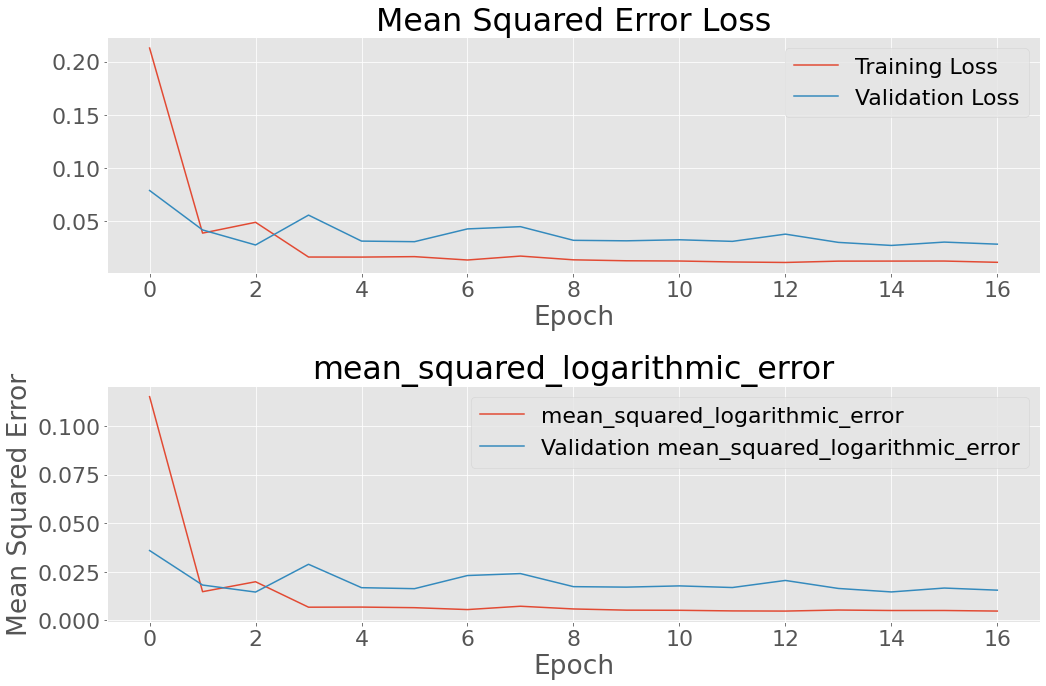

In [438]:
metrics = history.history
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(2, figsize=(15, 10))
axes[0].set_title('Mean Squared Error Loss')
axes[0].plot(history.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['Training Loss', 'Validation Loss'])
axes[0].set_xlabel('Epoch')

axes[1].set_title(metric)
axes[1].plot(history.epoch, metrics[metric], metrics['val_'+metric])
axes[1].legend([metric, 'Validation '+metric])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Squared Error')

fig.tight_layout()
plt.show()

In [439]:
prediction = model.predict(max_X_holdout)
predictions = prediction
predictions = max_holdout_scaler.inverse_transform(prediction)
targets = max_holdout_scaler.inverse_transform(max_y_holdout.reshape(-1, 1))

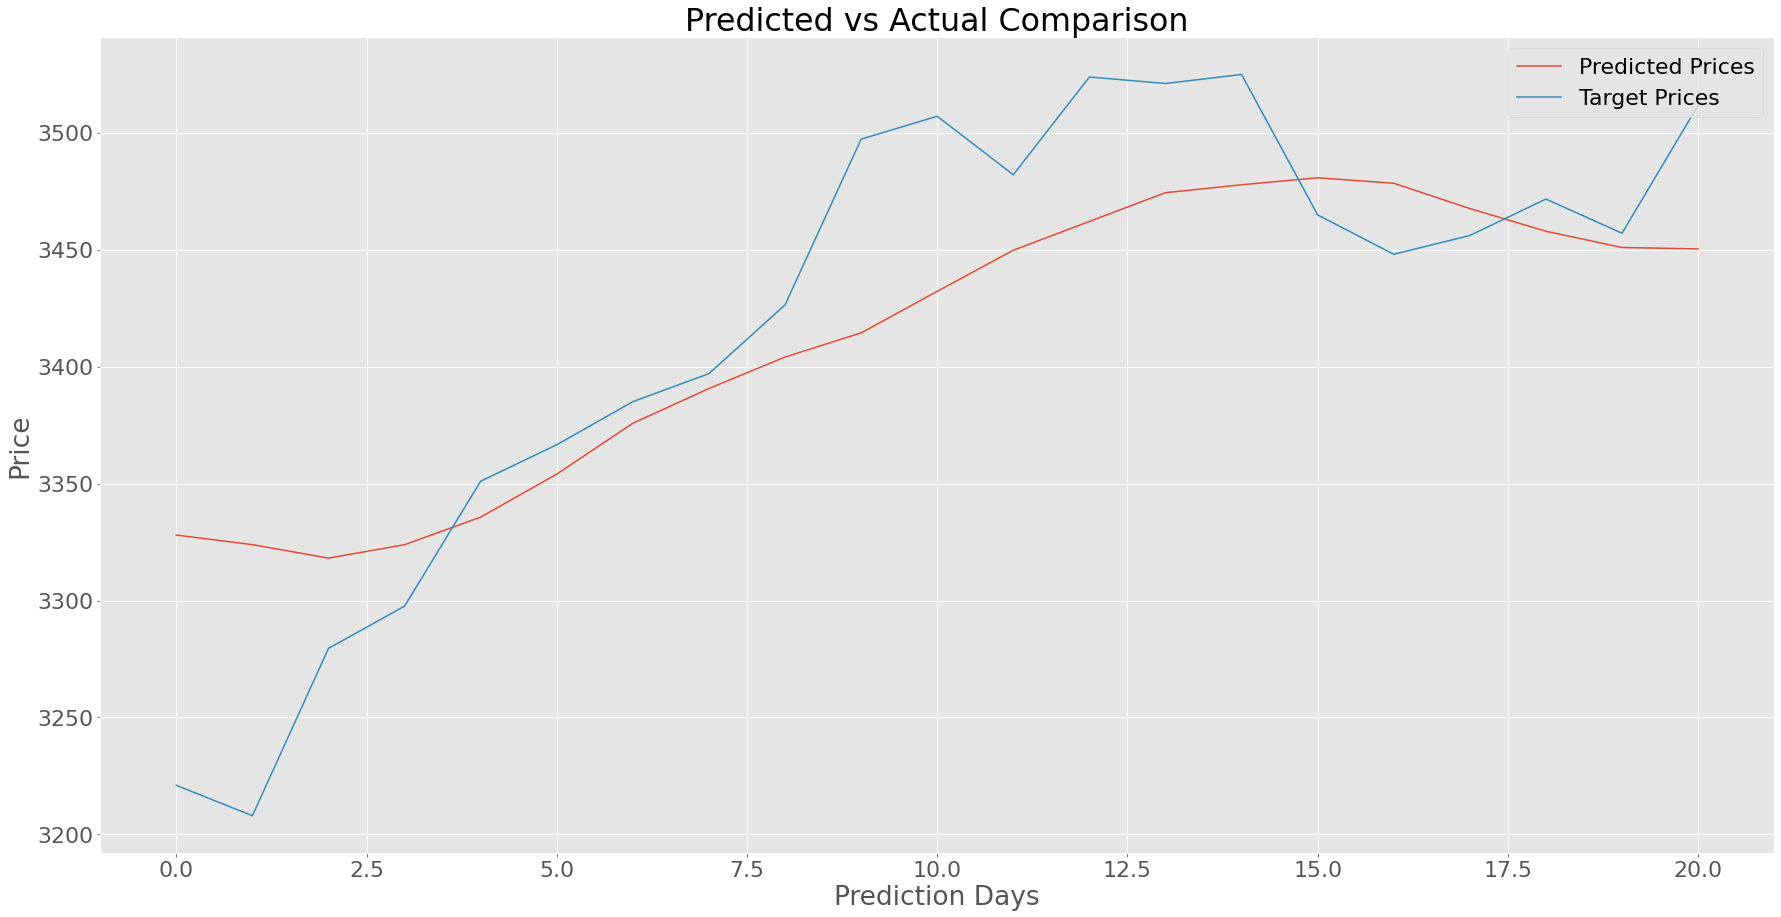

In [440]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(30, 15))
ax.set_title("Predicted vs Actual Comparison")
ax.plot(predictions)
ax.plot(target)
ax.legend(['Predicted Prices', 'Target Prices'], loc='upper right')

ax.set_xlabel('Prediction Days')
ax.set_ylabel('Price')

plt.show()

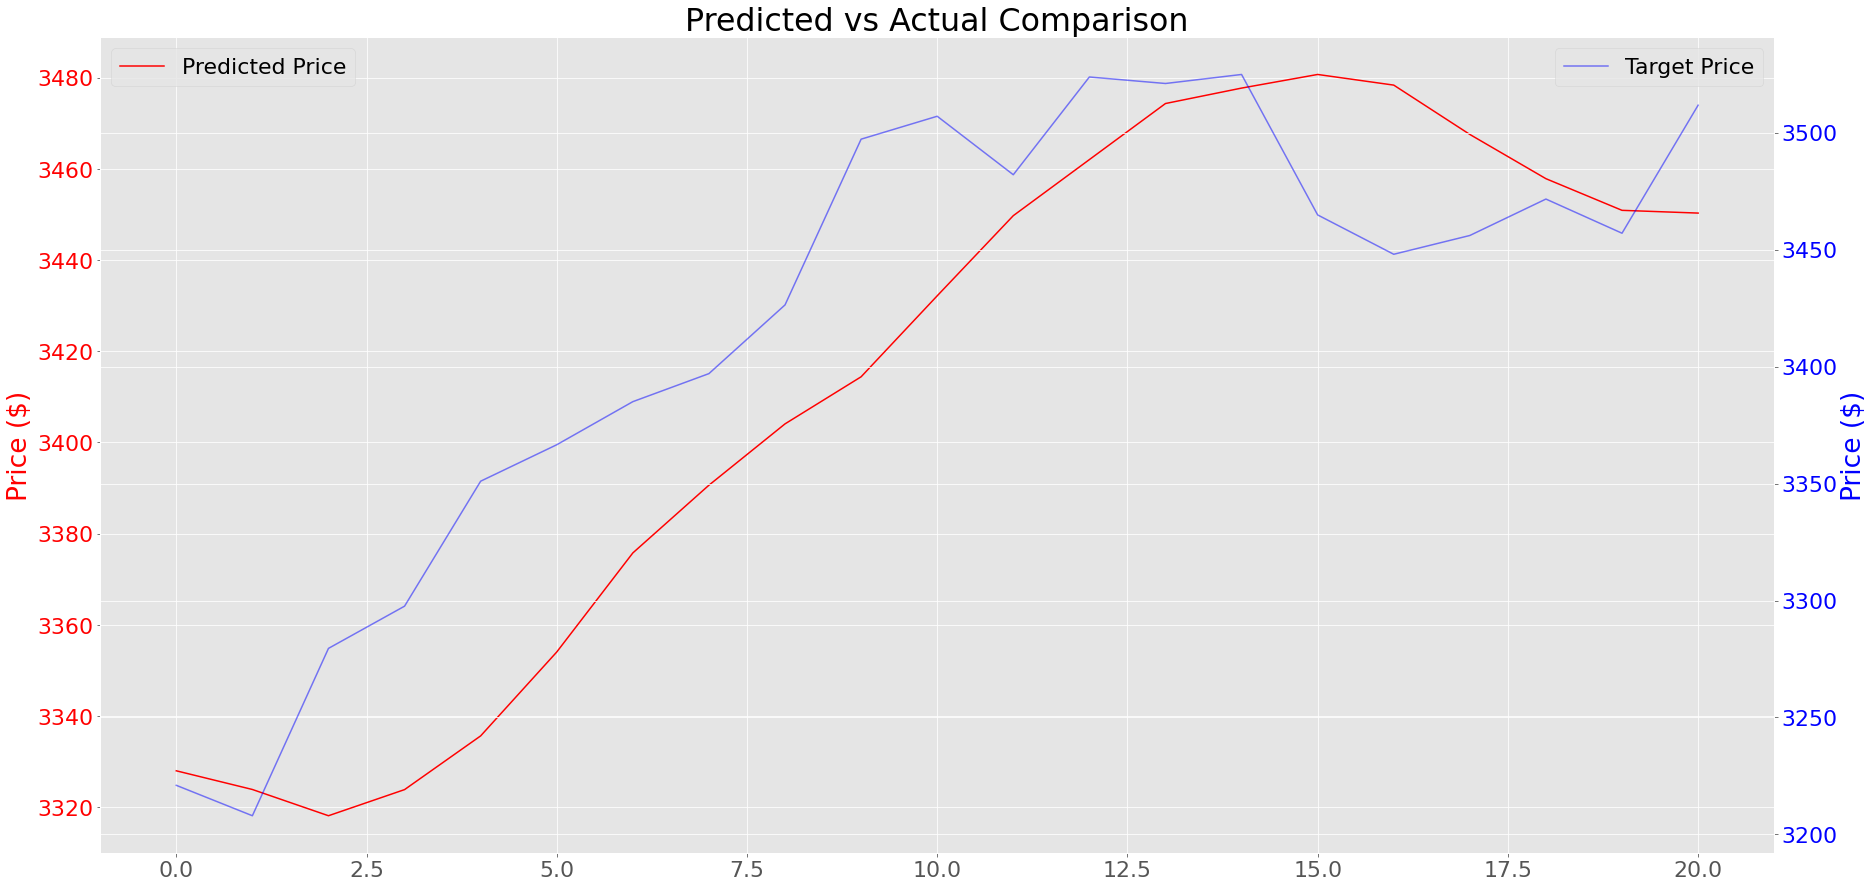

In [445]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

ax1.plot(range(len(predictions)), predictions, color='r', label='Predicted Price')
ax1.set_ylabel('Price ($)', color ='r')
ax1.set_title("Predicted vs Actual Comparison")
ax1.tick_params(axis='y', labelcolor='r')
ax1.ticklabel_format(useOffset=False, style='plain')

ax2 = ax1.twinx()
ax2.plot(range(len(targets)), targets, color='b', alpha=0.5, label='Target Price')
ax2.set_ylabel('Price ($)', color ='b')
ax2.tick_params(axis='y', labelcolor='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()